In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [3]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
#### Responsive params
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(dst_dir)

ROC 0.05
traces001|dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning


# Load data

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [5]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1257 |
| Lm |          1072 |
| Li |           644 |
|    |   visual_area |
|:---|--------------:|
| Li |            19 |
| Lm |            17 |
| V1 |            16 |


In [6]:
counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       644 |
| Lm            |      1072 |
| V1            |      1257 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       473 |        14 |
| Lm            |       685 |        11 |
| V1            |      1034 |         9 |


In [7]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='blobs',
                        images_only=False, rename=True,
                        return_incorrect=True, return_all=False)

In [8]:
incorrect_stim.keys()

dict_keys(['20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1'])

# Tuning curves

In [9]:
import analyze2p.objects.selectivity as sel

In [10]:
va='V1'
dk='20190616_JC097_fov1'
offset_type='none' # Already fixed per tuning curve
lcorrection='none'
with_lum = False

sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) & (NDATA0.config.isin(configs))].copy()
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)

ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf)
ixs_['visual_area'] = va
ixs_['datakey'] = dk


[0, 14, 27, 40, 53, 66, 79, 92, 106]


In [11]:
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

,cell,config,response,size,morphlevel
0,0,config006,0.043369,10.0,0
1,0,config007,0.032694,20.0,0
2,0,config008,0.059416,30.0,0
3,0,config009,0.072709,40.0,0
4,0,config010,0.151419,50.0,0


In [12]:
#### Generate morph tuning curves
morph_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
                x='morphlevel', y='size', normalize=True).reset_index(drop=True)
morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')
print(morph_curves['size'].unique())

#### Generate size tuning curves
size_curves = rdf.groupby(['cell']).apply(sel.get_x_curves_at_best_y, 
                                           x='size', y='morphlevel', normalize=True).reset_index(drop=True)
size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']
best_ixs.head()

[50. 20. 10. 30. 40.]


,cell,size_tol,morph_ix
cell,,,
0,0,0.343725,0.725903
1,1,0.447143,0.222986
2,2,0.339537,0.587511
9,9,0.362837,0.360534
11,11,0.366570,0.352886


In [13]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']
size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False

# V1: 20190616_JC097_fov1
# -----------------------
if va=='V1' and dk=='20190616_JC097_fov1':
    rois_plot_mp = [217, 388] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
    #rois_plot_sz = [405, 388] #405#[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()
    rois_plot_sz = [217, 388]
    cmaps=['cool', 'cool_r']
elif va=='Lm' and dk=='20190504_JC078_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    rois_plot_mp = [194, 185] #24]
    # rois_plot_sz = [294, 76] 
    rois_plot_sz = [194, 185]
    cmaps=['cool', 'cool_r']
    
elif va=='Li' and dk=='20190422_JC076_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [119, 76] 
    #rois_plot_sz = [293, 76] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']

elif va=='Li' and dk=='20190614_JC091_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [304, 234] #[331, 234] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']
lw=0.25

<IPython.core.display.Javascript object>


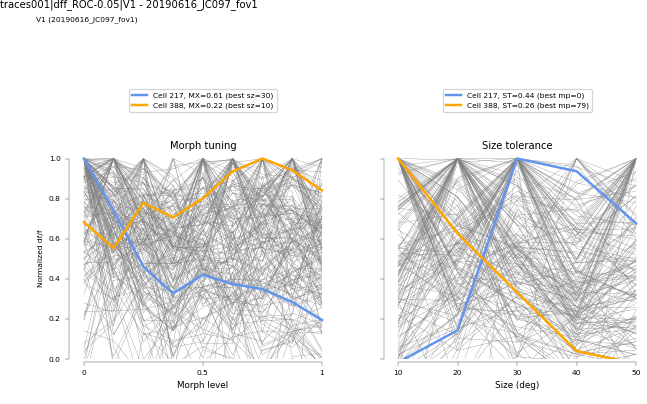

In [14]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(8,5), sharey=True)
ax=axn[0]
if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
ax.plot(mm.values, color='gray', alpha=1, lw=lw)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(mm['response', rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, MX=%.2f (best sz=%i)' 
            % (rid, best_ixs.loc[rid]['morph_ix'], best_sz))
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)
ax.set_xlabel(xlabel, fontsize=7)
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)
ax.set_ylim([0, 1])
# --------------------------------------------------------------
# Size Tolerance
# --------------------------------------------------------------
ax=axn[1]
rank_order=False
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0)
    sz = xx[::-1]
else:
    sz = size_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=lw)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())
    ax.plot(sz['response', rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, ST=%.2f (best mp=%i)'
            % (rid, best_ixs.loc[rid]['size_tol'], best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) # if rank_order else size_labels
ax.set_xticks(xticks)
ax.set_xticklabels(size_labels)

ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (va, dk), fontsize=6)

pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)

In [24]:
morph_curves.head()

,cell,config,response,size,morphlevel
0,0,config010,1.000000,50.0,0
1,0,config015,0.403994,50.0,14
2,0,config020,0.653277,50.0,27
3,0,config025,0.015066,50.0,40
4,0,config030,0.369948,50.0,53


In [25]:
morph_curves[(morph_curves.response==1) & (morph_curves.morphlevel==0)]

,cell,config,response,size,morphlevel
0,0,config010,1.0,50.0,0
54,15,config010,1.0,50.0,0
117,25,config008,1.0,30.0,0
126,30,config007,1.0,20.0,0
144,34,config007,1.0,20.0,0
...,...,...,...,...,...
1530,409,config010,1.0,50.0,0
1539,410,config010,1.0,50.0,0
1593,420,config008,1.0,30.0,0
1620,424,config006,1.0,10.0,0


In [34]:
morph_curves[(morph_curves.response==1) & (morph_curves.morphlevel==106)]

,cell,config,response,size,morphlevel
89,20,config046,1.0,10.0,106
206,51,config048,1.0,30.0,106
278,65,config046,1.0,10.0,106
341,90,config047,1.0,20.0,106
359,94,config047,1.0,20.0,106
800,204,config047,1.0,20.0,106
935,230,config047,1.0,20.0,106
1052,264,config048,1.0,30.0,106
1340,377,config047,1.0,20.0,106


In [19]:
from scipy import signal

In [40]:
%matplotlib notebook
# r1 =217
# r2=388
r1 =0
r2= 65

curve1 = morph_curves[morph_curves['cell']==r1]\
            .sort_values(by='morphlevel')['response'].values

curve2 = morph_curves[morph_curves['cell']==r2]\
            .sort_values(by='morphlevel')['response'].values

<IPython.core.display.Javascript object>


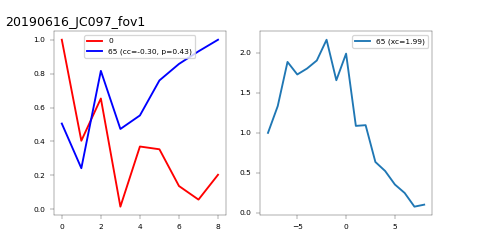

Text(0.01, 0.9, '20190616_JC097_fov1')

In [41]:
# r2 = 116
#r2 = 281
c1='r'
c2='b'
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(curve1, label=r1, color=c1)
cc, pv = spstats.pearsonr(curve1, curve2)
axn[0].plot(curve2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv), color=c2)
# ax.plot(curve2, label=r2, color=c2)
ax.legend()

ccorr = signal.correlate(curve1, curve2)
lags = signal.correlation_lags(len(curve1), len(curve1))

#ax.legend()
lagzero = list(lags).index(0)
xcorr = ccorr[lagzero]

axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr))
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.2)
axn[1].legend()

fig.text(0.01, 0.9, dk)

In [42]:
ccorr /= np.max(ccorr)

In [43]:
ccorr

array([0.46210827, 0.61718265, 0.87192644, 0.79942542, 0.83378248,
       0.88014083, 1.        , 0.76611466, 0.91978596, 0.50244244,
       0.50660384, 0.29410254, 0.24194389, 0.1637488 , 0.11497798,
       0.03596239, 0.04745936])